In [ ]:
!pip install tensorflow tensorflow-datasets matplotlib scikit-learn opencv-python segmentation-models pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, precision_score, recall_score

print("TensorFlow version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())

TensorFlow version: 2.18.0
Eager execution: True


In [ ]:
IMG_SIZE = 128  # resize images to 128x128
BATCH_SIZE = 16
NUM_CLASSES = 3  # background, pet, and border (depending on dataset specifics)

def normalize(input_image, input_mask):
    # i am normalising the image to [0,1]
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int32) - 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

# here i am loading the dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

TRAIN_LENGTH = info.splits['train'].num_examples

train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train.cache().shuffle(TRAIN_LENGTH).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

print("Dataset prepared.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.AYKG93_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.AYKG93_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Dataset prepared.


In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_size)

    # encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # the bottleneck
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    # decoder part
    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1,1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# to train the model
EPOCHS = 30

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=test_dataset)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


230/230 ━━━━━━━━━━━━━━━━━━━━ 53s 126ms/step - accuracy: 0.5687 - loss: 0.9247 - val_accuracy: 0.7182 - val_loss: 0.6833
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.7345 - loss: 0.6551 - val_accuracy: 0.7334 - val_loss: 0.6513
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.7762 - loss: 0.5655 - val_accuracy: 0.8124 - val_loss: 0.4800
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.8092 - loss: 0.4903 - val_accuracy: 0.8149 - val_loss: 0.4764
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.8255 - loss: 0.4551 - val_accuracy: 0.8261 - val_loss: 0.4520
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.8390 - loss: 0.4178 - val_accuracy: 0.8412 - val_loss: 0.4076
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.8514 - loss: 0.3857 - val_accuracy: 0.8392 - val_loss: 0.4160
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.8573 - loss: 0.3733 - val_accura

In [ ]:
y_true = []
y_pred = []

for images, masks in test_dataset:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1)
    preds = preds.numpy().flatten()
    masks = masks.numpy().flatten()
    y_pred.extend(preds)
    y_true.extend(masks)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# to compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
print("Confusion Matrix:")
print(cm)

# to calculate precision and recall
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

print("\nPrecision (macro): {:.2f}%".format(precision * 100))
print("Recall (macro): {:.2f}%".format(recall * 100))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

In [ ]:
def display_sample(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        # here we to convert to numpy if tensor or it can raize issue or error
        img = display_list[i].numpy() if tf.is_tensor(display_list[i]) else display_list[i]
        plt.imshow(img)
        plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


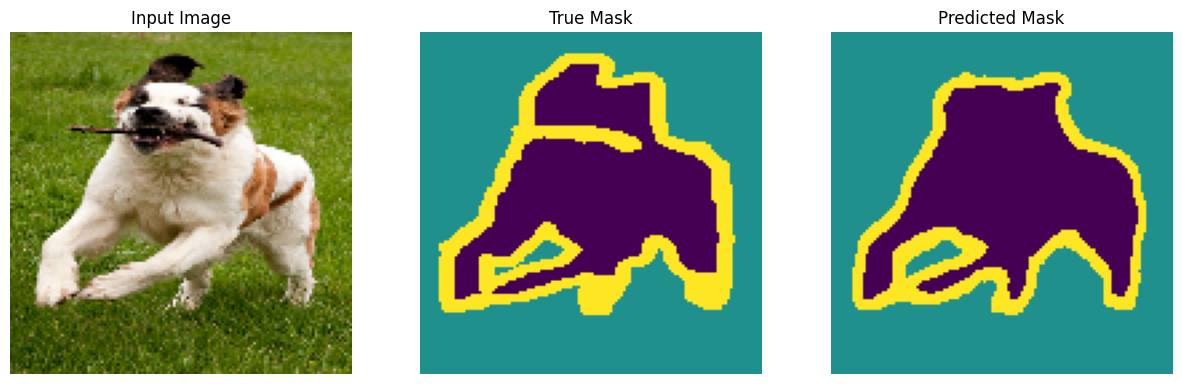

In [ ]:
for image, mask in test_dataset.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    sample_image = image[2]
    sample_mask = mask[2]
    sample_pred_mask = pred_mask[2]

    # and now we remove extra dimensions to match (H, W, C)
    sample_mask = tf.squeeze(sample_mask, axis=-1)
    sample_pred_mask = tf.squeeze(sample_pred_mask, axis=-1)

    display_sample([sample_image, sample_mask, sample_pred_mask])
    break

Please upload an image to test...


Saving cat.jpeg to cat.jpeg
Processing cat.jpeg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


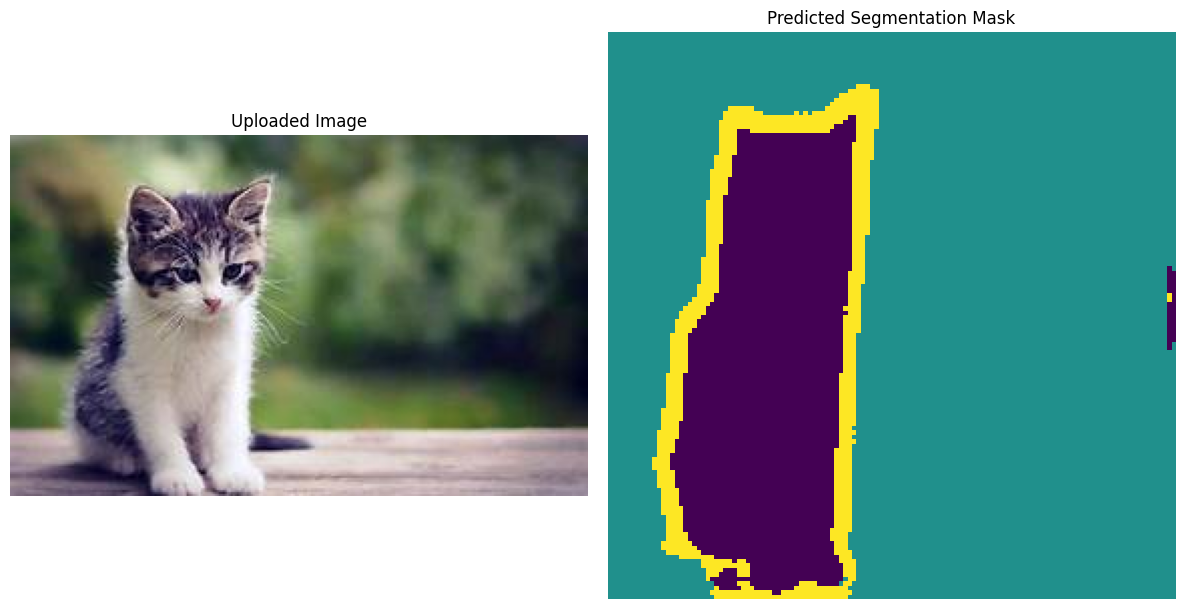

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def process_uploaded_image(uploaded_img_path):
    # Read the image
    img = cv2.imread(uploaded_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to match model's expected input
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalize the image
    img_normalized = img_resized / 255.0

    # Create batch dimension
    img_batch = np.expand_dims(img_normalized, axis=0)

    return img, img_batch

def test_with_uploaded_image():
    # Upload an image
    print("Please upload an image to test...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing {filename}...")

        # Process the image
        original_img, img_batch = process_uploaded_image(filename)

        # Make prediction
        pred_mask = model.predict(img_batch)
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[0].numpy()  # Remove batch dimension

        # Display results
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title('Uploaded Image')
        plt.imshow(original_img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Predicted Segmentation Mask')
        plt.imshow(pred_mask)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Call the function to test with your own image
test_with_uploaded_image()

In [ ]:
# Save the entire model (architecture + weights) to a single HDF5 file
model.save('my_unet_model.h5')

In [ ]:
from google.colab import files
files.download('my_unet_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>